# Recurring Times - Interactive Maps with LEAFMAP

## Imports

In [1]:
# %pip install leafmap --quiet --no-cache-dir

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import copy
from unidecode import unidecode
import pandas as pd
import geopandas as gpd
from scipy import stats

from pathlib import Path
from pretty_html_table import build_table
from jinja2 import Environment
from jinja2 import FileSystemLoader

from hydrology.hydrology import Hydrology
from hydrology.utils import disable_warnings, fig2base64

import leafmap

In [4]:
disable_warnings()

In [5]:
hydro = Hydrology()

## Read stations

In [6]:
stations = gpd.read_file("../../tmp/Estacoes_Cheias_RS.geojson", driver="GeoJSON")
stations.drop(columns=["Unnamed: 0"], inplace=True)
stations.set_index('Codigo', inplace=True)
stations.head()

Bacia            Estacao  Cota    Vazao       Data  Latitude  \
Codigo                                                                     
86472600  Taquari       Santa Tereza  2232      NaN 2024-02-05  -29.1781   
86510000  Taquari              Muçum  2557  13242.0 2024-02-05  -29.1672   
86879300  Taquari            Estrela  3335  22951.0 2024-02-05  -29.4733   
86882000  Taquari  Bom Retiro do Sul  2174      NaN 2024-02-05  -29.6164   
85400000    Jacuí     Dona Francisca  1113   3823.0 2024-04-30  -29.6269   

          Longitude  Telemetrica                     geometry  
Codigo                                                         
86472600   -51.7322         True  POINT (-51.73220 -29.17810)  
86510000   -51.8686         True  POINT (-51.86860 -29.16720)  
86879300   -51.9622         True  POINT (-51.96220 -29.47330)  
86882000   -51.9383        False  POINT (-51.93830 -29.61640)  
85400000   -53.3528         True  POINT (-53.35280 -29.62690)

## Get Metadata From Hidro

In [7]:
stats = pd.Series()

# update the stations table with Hydro stats
for station in stations.index:
    try:
        stats[station] = hydro.get_station_stats(station)
    except:
        stats[station] = None


In [8]:
stats_df = pd.json_normalize(stats)
stats_df.index = stats.index


In [9]:
import numpy as np
stations1 = pd.concat(
    [
        stations[['Estacao', 'Bacia', 'Latitude', 'Longitude']],
        stats_df[['start_year', 'end_year', 'years', 'missing_perc']]
    ], 
    axis=1
)

stations1.rename(
    columns={
        'start_year': 'Inicio',
        'end_year': 'Fim',
        'years': 'Anos',
        'missing_perc': 'Falhas (%)'
    },
    inplace=True
)

stations1['Anos'] = stations1['Anos'].apply(lambda x: int(x) if not pd.isna(x) else ' - ')
stations1 = stations1.applymap(lambda x: ' - ' if pd.isnull(x) else x)
stations1

Estacao    Bacia  Latitude  Longitude   Inicio      Fim  \
86472600         Santa Tereza  Taquari  -29.1781   -51.7322       -        -    
86510000                Muçum  Taquari  -29.1672   -51.8686  1940/01  2024/01   
86879300              Estrela  Taquari  -29.4733   -51.9622       -        -    
86882000    Bom Retiro do Sul  Taquari  -29.6164   -51.9383       -        -    
85400000       Dona Francisca    Jacuí  -29.6269   -53.3528  1939/12  2024/01   
85900000            Rio Pardo    Jacuí  -29.9950   -52.3756  1939/12  2024/01   
87165000                Feliz      Caí  -29.4550   -51.3061       -        -    
87170000         Barra do Caí      Caí  -29.5900   -51.3833  1978/01  2024/01   
87230000  Costa do rio Cadeia      Caí  -29.5906   -51.3136  2010/01  2024/01   
75230000         Santo Angelo  Uruguai  -28.3553   -54.2675  1941/11  2024/01   
74100000                 Iraí  Uruguai  -27.1756   -53.2297  1948/08  2024/01   
74329000           Itapiranga  Uruguai  -27.1717   -53.7097  2015/03  2024/01   
74720000           Porto Maua  Uruguai  -27.5781   -54.6831  2018/12  2021/12   
74800000         Porto Lucena  Uruguai  -27.8525   -55.0256  1983/01  2024/01   
75550000            Garruchos  Uruguai  -28.1822   -55.6433  1983/01  2024/01   
76560000         Manoel Viana  Uruguai  -29.5958   -55.4814  1967/06  2024/01   
76750000             Alegrete  Uruguai  -29.7683   -55.7875  1940/10  2024/01   

         Anos Falhas (%)  
86472600   -          -   
86510000   83      0.50%  
86879300   -          -   
86882000   -          -   
85400000   83      0.30%  
85900000   75     10.59%  
87165000   -          -   
87170000   45      2.17%  
87230000   12     10.65%  
75230000   82      0.30%  
74100000   59     20.75%  
74329000    8      2.80%  
74720000    3      0.00%  
74800000   40      1.01%  
75550000   27     33.47%  
76560000   56      0.59%  
76750000   82      0.70%

## Stage-Curves

In [29]:
hydro._connect_datalake()

In [30]:
for station in stations1.index:
    cc = pd.read_sql_query(f"SELECT * FROM hidro.curvadescarga WHERE EstacaoCodigo = {station}", con=hydro.conn)
    cc.to_csv(f"../../tmp/Curva_descarga_{station}.csv") # , sep=';', decimal=',')
    

In [10]:
hydro.get_station_stats(station=86510000)

{'complete_months': 1004,
 'years': 83,
 'start_year': '1940/01',
 'end_year': '2024/01',
 'total_months': 1009,
 'missing_perc': '0.50%'}

## The Map

In [8]:
import folium

In [9]:
y, x = -29.010922, -52.949992
xmin = -57.86
ymin = -32.5
xmax = -48.59
ymax = -22.5


### Add Stations as ad-hoc markers

In [10]:
gdf

Unnamed: 0    Bacia              Estacao    Codigo  Cota    Vazao  \
0            0  Taquari         Santa Tereza  86472600  2232      NaN   
1            1  Taquari                Muçum  86510000  2557  13242.0   
2            2  Taquari              Estrela  86879300  3335  22951.0   
3            3  Taquari    Bom Retiro do Sul  86882000  2174      NaN   
4            4    Jacuí       Dona Francisca  85400000  1113   3823.0   
5            5    Jacuí            Rio Pardo  85900000  2004  13547.0   
6            6      Caí                Feliz  87165000  1401      NaN   
7            7      Caí         Barra do Caí  87170000  1760      NaN   
8            8      Caí  Costa do rio Cadeia  87230000  1208    325.0   
9            9  Uruguai         Santo Angelo  75230000   763   2885.0   
10          10  Uruguai                 Iraí  74100000  1267  26050.0   
11          11  Uruguai           Itapiranga  74329000  1186  25710.0   
12          12  Uruguai           Porto Maua  74720000  1500      NaN   
13          13  Uruguai         Porto Lucena  74800000  1153  39771.0   
14          14  Uruguai            Garruchos  75550000  1746  26375.0   
15          15  Uruguai         Manoel Viana  76560000  1482   8028.0   
16          16  Uruguai             Alegrete  76750000  1280   1153.0   

         Data  Latitude  Longitude  Telemetrica                     geometry  
0  2024-02-05  -29.1781   -51.7322         True  POINT (-51.73220 -29.17810)  
1  2024-02-05  -29.1672   -51.8686         True  POINT (-51.86860 -29.16720)  
2  2024-02-05  -29.4733   -51.9622         True  POINT (-51.96220 -29.47330)  
3  2024-02-05  -29.6164   -51.9383        False  POINT (-51.93830 -29.61640)  
4  2024-04-30  -29.6269   -53.3528         True  POINT (-53.35280 -29.62690)  
5  2024-05-05  -29.9950   -52.3756         True  POINT (-52.37560 -29.99500)  
6  2024-02-05  -29.4550   -51.3061        False  POINT (-51.30610 -29.45500)  
7  2024-02-05  -29.5900   -51.3833         True  POINT (-51.38330 -29.59000)  
8  2024-01-05  -29.5906   -51.3136         True  POINT (-51.31360 -29.59060)  
9  2024-05-05  -28.3553   -54.2675         True  POINT (-54.26750 -28.35530)  
10 2024-03-05  -27.1756   -53.2297         True  POINT (-53.22970 -27.17560)  
11 2024-03-05  -27.1717   -53.7097         True  POINT (-53.70970 -27.17170)  
12 2024-04-05  -27.5781   -54.6831         True  POINT (-54.68310 -27.57810)  
13 2024-05-05  -27.8525   -55.0256         True  POINT (-55.02560 -27.85250)  
14 2024-06-05  -28.1822   -55.6433         True  POINT (-55.64330 -28.18220)  
15 2024-06-05  -29.5958   -55.4814         True  POINT (-55.48140 -29.59580)  
16 2024-03-05  -29.7683   -55.7875         True  POINT (-55.78750 -29.76830)

In [11]:
from pathlib import Path
import branca
import unidecode

In [12]:
root = Path('/data/Vulnerability_output/RecurringTimes/IncludingMaxDischarges')

def load_html(station_name):
    station_name = unidecode.unidecode(station_name).replace(' ', '_')
    path = root/f'{station_name}.html'

    if path.exists():
        with open(path, 'r') as f:
            html = f.read()
        return html
    
    return None
# with open(root/'Alegrete.html', 'r') as f:
#     html = f.read()

In [13]:
m = folium.Map(
    max_bounds=True,
    location=(y, x),
    zoom_start=7,
    min_lat=ymin,
    min_lon=xmin,
    max_lat=ymax,
    max_lon=xmax,
    max_zoom=15,
    min_zoom=7
)

for idx, row in gdf.iterrows():
    lat, lon = row['Latitude'], row['Longitude'] 
    
    # before creating the marker, let's create an iframe with branca
    # the icon and popup depends on the type of station/discharges
    html = load_html(row['Estacao'])
    if not pd.isna(row['Vazao']) and html is not None:
        iframe = branca.element.IFrame(html=html, width=950, height=400)
        popup = folium.Popup(iframe, max_width=950)
        icon=folium.Icon(icon='water', color='blue', prefix='fa')
    else:
        icon=folium.Icon(icon='water', color='red', prefix='fa')
        popup=None
    

    # create the main marker
    marker = folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=icon,
        # popup=f"<b>Name</b>: {row['Estacao']}<br><b>Code:</b> {row['Codigo']}",
        # icon=folium.Icon(icon='water', color=marker_color[row['Telemetrica']], prefix='fa')
    )

    # create marker labels
    label = folium.Marker(
        location=[lat, lon],
        icon=folium.DivIcon(
            icon_size=(150,50),
            icon_anchor=(0, 0),
            html=f"<div style='font-size: 14px; font-weight: bold;'>{row['Estacao']}</div>"
        )
    )        
    

    m.add_child(marker)
    m.add_child(label)

m

In [14]:
m.save('/data/Vulnerability_output/RecurringTimes/tempos_retorno.html')

### Add Geojson at once

In [25]:
m = folium.Map(
    max_bounds=True,
    location=(y, x),
    zoom_start=7,
    min_lat=ymin,
    min_lon=xmin,
    max_lat=ymax,
    max_lon=xmax,
    max_zoom=15,
    min_zoom=7
)

folium.GeoJson('../../tmp/Estacoes_Cheias_RS.geojson').add_to(m)
m

In [10]:
import ipyleaflet

In [11]:
ipyleaflet.Map?

Init signature: ipyleaflet.Map(**kwargs)
Docstring:     
Map class.

The Map class is the main widget in ipyleaflet.

Attributes
----------
layers: list of Layer instances
    The list of layers that are currently on the map.
controls: list of Control instances
    The list of controls that are currently on the map.
center: list, default [0, 0]
    The current center of the map.
zoom: float, default 12
    The current zoom value of the map.
max_zoom: float, default None
    Maximal zoom value.
min_zoom: float, default None
    Minimal zoom value.
zoom_snap: float, default 1
    Forces the map’s zoom level to always be a multiple of this.
zoom_delta: float, default 1
    Controls how much the map’s zoom level will change after
    pressing + or - on the keyboard, or using the zoom controls.
crs: projection, default projections.EPSG3857
    Coordinate reference system, which can be ‘Earth’, ‘EPSG3395’, ‘EPSG3857’,
    ‘EPSG4326’, ‘Base’, ‘Simple’ or user defined projection.
dragging: boo

In [9]:
m = leafmap.Map(center=(40, -100), zoom=4)
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [21]:
m.add_point_layer('../../tmp/Estacoes_Cheias_RS.geojson', popup='Estacao')

## Base Functions

In [58]:
# Main function to create the HTML 

jinja_env = Environment(loader=FileSystemLoader('./templates'))
template = jinja_env.get_template('trs.html')


def calc_recurring_times(row: pd.Series, include_max_q: bool=True):

    if pd.isna(row['Vazao']):
        raise ValueError(f'No discharge for station {row["Codigo"]}')

    # Get discharge from Hidro
    q = hydro.get_discharge(row['Codigo'])
    if len(q) <= 10:
        raise ValueError(f'No discharge series for station {row["Codigo"]}')

    # Include the maximum Discharge from this year
    q.loc[row['Data'], ['NivelConsistencia', 'EstacaoCodigo', 'Vazao']] = (1, row['Codigo'], row['Vazao'])
    maximum, fig = Hydrology.calc_return_times(q, 1, include_max_q=include_max_q)

    return maximum, fig

def create_html_report(row: pd.Series, include_max_q: bool=True):

    try:
        maximum, fig = calc_recurring_times(row, include_max_q=include_max_q)

        # Prepare data for the HTML page
        jinja_data = {
            'place': row['Estacao'] + '(' + str(row['Codigo']) + ')',
            'date': row['Data'],
            'hydrology_table': build_table(
                maximum.head(30), 
                color="blue_light",
                font_size='small',
                width_dict=["16%", "16%", "32%", "12%", "12%", "12%"]
            ),
            'hydrology_figure': fig2base64(fig)
        }
        html = template.render(jinja_data)

        return html
                

    except Exception as e:
        print(f'Error for station {row["Codigo"]}: {e}')
        


## Main Loop

In [81]:
base_dir = Path('/data/Vulnerability_output/RecurringTimes/')

for idx, row in df.iterrows():

    print(f'Processing stations {row["Estacao"]} - {row["Codigo"]}')

    # Create the HTML report for the station
    html = create_html_report(row, include_max_q=False)
    if html is None:
        continue

    # define output directory and file name
    outpath = base_dir/(unidecode(row['Estacao']).replace(' ', '_') + '.html')
    with open(outpath, "w", encoding="utf-8") as f:
        f.write(html) 

Processing stations Santa Tereza - 86472600
Error for station 86472600: No discharge for station 86472600
Processing stations Muçum - 86510000
Processing stations Estrela - 86879300
Error for station 86879300: No discharge series for station 86879300
Processing stations Bom Retiro do Sul - 86882000
Error for station 86882000: No discharge for station 86882000
Processing stations Dona Francisca - 85400000
Processing stations Rio Pardo - 85900000
Processing stations Feliz - 87165000
Error for station 87165000: No discharge for station 87165000
Processing stations Barra do Caí - 87170000
Processing stations Costa do rio Cadeia - 87230000
Processing stations Santo Angelo - 75230000
Processing stations Iraí - 74100000
Processing stations Itapiranga - 74329000
Processing stations Porto Maua - 74720000
Processing stations Porto Lucena - 74800000
Processing stations Garruchos - 75550000
Processing stations Manoel Viana - 76560000
Processing stations Alegrete - 76750000


In [80]:
q = hydro.get_discharge(76750000)
q.index.min()

Timestamp('1940-10-22 00:00:00')

## Skeweness and Kurtosis

In [106]:
from scipy.stats import lognorm, gumbel_r, skew, kurtosis
import numpy as np


In [111]:
for idx, row in df.iterrows():
    try:
        maximum, fig = calc_recurring_times(row, include_max_q=True)

        try:
            sk = skew(maximum['Vazao'][1:])
        except:
            sk = None

        try: 
            kurt = kurtosis(maximum['Vazao'][1:])
        except:
            kurt = None
            
        df.loc[idx, ['skew', 'kurt']] = [sk, kurt]

    except Exception as e:
        print(e)
        continue
    pass

No discharge for station 86472600
No discharge series for station 86879300
No discharge for station 86882000
No discharge for station 87165000


In [112]:
df

Bacia              Estacao    Codigo  Cota    Vazao       Data  \
0   Taquari         Santa Tereza  86472600  2232      NaN 2024-02-05   
1   Taquari                Muçum  86510000  2557  13242.0 2024-02-05   
2   Taquari              Estrela  86879300  3335  22951.0 2024-02-05   
3   Taquari    Bom Retiro do Sul  86882000  2174      NaN 2024-02-05   
4     Jacuí       Dona Francisca  85400000  1113   3823.0 2024-04-30   
5     Jacuí            Rio Pardo  85900000  2004  13547.0 2024-05-05   
6       Caí                Feliz  87165000  1401      NaN 2024-02-05   
7       Caí         Barra do Caí  87170000  1760   1855.0 2024-02-05   
8       Caí  Costa do rio Cadeia  87230000  1208    325.0 2024-01-05   
9   Uruguai         Santo Angelo  75230000   763   2885.0 2024-05-05   
10  Uruguai                 Iraí  74100000  1267  26050.0 2024-03-05   
11  Uruguai           Itapiranga  74329000  1186  25710.0 2024-03-05   
12  Uruguai           Porto Maua  74720000  1500  27665.0 2024-04-05   
13  Uruguai         Porto Lucena  74800000  1153  39771.0 2024-05-05   
14  Uruguai            Garruchos  75550000  1746  26375.0 2024-06-05   
15  Uruguai         Manoel Viana  76560000  1482   8028.0 2024-06-05   
16  Uruguai             Alegrete  76750000  1280   1153.0 2024-03-05   

    Latitude  Longitude Telemetrica      skew      kurt  
0   -29.1781   -51.7322        True       NaN       NaN  
1   -29.1672   -51.8686        True  0.431472 -0.570015  
2   -29.4733   -51.9622        True       NaN       NaN  
3   -29.6164   -51.9383       False       NaN       NaN  
4   -29.6269   -53.3528        True -0.641150  0.028479  
5   -29.9950   -52.3756        True  0.563814  0.749016  
6   -29.4550   -51.3061       False       NaN       NaN  
7   -29.5900   -51.3833        True -0.120032 -0.673794  
8   -29.5906   -51.3136        True  0.371986 -1.025691  
9   -28.3553   -54.2675        True  1.177630  1.371315  
10  -27.1756   -53.2297        True  0.982286  0.693873  
11  -27.1717   -53.7097        True  0.126718 -1.708020  
12  -27.5781   -54.6831        True -0.448176 -1.325818  
13  -27.8525   -55.0256        True  0.834734  0.399001  
14  -28.1822   -55.6433        True  0.238494 -0.589879  
15  -29.5958   -55.4814        True  0.795262  0.063817  
16  -29.7683   -55.7875        True -0.122909 -0.613278

In [108]:
df

Bacia              Estacao    Codigo  Cota    Vazao       Data  \
0   Taquari         Santa Tereza  86472600  2232      NaN 2024-02-05   
1   Taquari                Muçum  86510000  2557  13242.0 2024-02-05   
2   Taquari              Estrela  86879300  3335  22951.0 2024-02-05   
3   Taquari    Bom Retiro do Sul  86882000  2174      NaN 2024-02-05   
4     Jacuí       Dona Francisca  85400000  1113   3823.0 2024-04-30   
5     Jacuí            Rio Pardo  85900000  2004  13547.0 2024-05-05   
6       Caí                Feliz  87165000  1401      NaN 2024-02-05   
7       Caí         Barra do Caí  87170000  1760   1855.0 2024-02-05   
8       Caí  Costa do rio Cadeia  87230000  1208    325.0 2024-01-05   
9   Uruguai         Santo Angelo  75230000   763   2885.0 2024-05-05   
10  Uruguai                 Iraí  74100000  1267  26050.0 2024-03-05   
11  Uruguai           Itapiranga  74329000  1186  25710.0 2024-03-05   
12  Uruguai           Porto Maua  74720000  1500  27665.0 2024-04-05   
13  Uruguai         Porto Lucena  74800000  1153  39771.0 2024-05-05   
14  Uruguai            Garruchos  75550000  1746  26375.0 2024-06-05   
15  Uruguai         Manoel Viana  76560000  1482   8028.0 2024-06-05   
16  Uruguai             Alegrete  76750000  1280   1153.0 2024-03-05   

    Latitude  Longitude Telemetrica      skew       kurt  
0   -29.1781   -51.7322        True       NaN        NaN  
1   -29.1672   -51.8686        True  0.487152  -0.476396  
2   -29.4733   -51.9622        True       NaN        NaN  
3   -29.6164   -51.9383       False       NaN        NaN  
4   -29.6269   -53.3528        True -0.036161   1.360726  
5   -29.9950   -52.3756        True  1.999065   8.129185  
6   -29.4550   -51.3061       False       NaN        NaN  
7   -29.5900   -51.3833        True  1.215865   3.930825  
8   -29.5906   -51.3136        True  1.010781   0.583159  
9   -28.3553   -54.2675        True  3.916972  22.586164  
10  -27.1756   -53.2297        True  1.204690   1.415977  
11  -27.1717   -53.7097        True  0.029049  -1.640749  
12  -27.5781   -54.6831        True  0.996521  -0.305911  
13  -27.8525   -55.0256        True  0.959110   0.553715  
14  -28.1822   -55.6433        True  0.383391  -0.435205  
15  -29.5958   -55.4814        True  0.988331   0.639664  
16  -29.7683   -55.7875        True  0.123813  -0.080287

In [103]:
skew(maximum['Vazao'])

0.1238127625322594

In [100]:
args = gumbel_r.fit(maximum['Vazao'])

gumbel_r.stats(*args, moments='s')

1.1395470994046486

In [101]:
args = lognorm.fit(maximum['Vazao'])

lognorm.stats(*args, moments='s')

0.1444465202551067

Estações que não possuem série longa (menor que 15 anos) e que não tiveram ajuste aceitável:

* Porto Mauá (74720000): 2018->
* Itapiranga (74329000): 2015->
* Costa do rio Cadeia (87230000): 2010->

In [12]:
maximum.head(3)

Ano Hidro   Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0  1941/1942  4984.2 1941-05-05         87.0     33528.8         64.5
1  2024/2025  3823.0 2024-04-30         43.5        91.6         13.7
2  1997/1998  3560.4 1997-10-16         29.0        35.2          9.8

In [67]:
df.to_csv('../../tmp/Estacoes_Cheias_RS.csv')

In [64]:
stations['TipoEstacaoTelemetrica'].astype('bool')

0        False
1        False
2         True
3         True
4        False
         ...  
38135    False
38136    False
38137    False
38138    False
38139    False
Name: TipoEstacaoTelemetrica, Length: 38140, dtype: bool

In [47]:
stations.columns

Index(['RegistroID', 'Descricao', 'Importado', 'Temporario', 'Removido',
       'ImportadoRepetido', 'BaciaCodigo', 'SubBaciaCodigo', 'RioCodigo',
       'EstadoCodigo', 'MunicipioCodigo', 'ResponsavelCodigo',
       'ResponsavelUnidade', 'ResponsavelJurisdicao', 'OperadoraCodigo',
       'OperadoraUnidade', 'OperadoraSubUnidade', 'TipoEstacao', 'Codigo',
       'Nome', 'CodigoAdicional', 'Latitude', 'Longitude', 'Altitude',
       'AreaDrenagem', 'TipoEstacaoEscala', 'TipoEstacaoRegistradorNivel',
       'TipoEstacaoDescLiquida', 'TipoEstacaoSedimentos',
       'TipoEstacaoQualAgua', 'TipoEstacaoPluviometro',
       'TipoEstacaoRegistradorChuva', 'TipoEstacaoTanqueEvapo',
       'TipoEstacaoClimatologica', 'TipoEstacaoPiezometria',
       'TipoEstacaoTelemetrica', 'PeriodoEscalaInicio', 'PeriodoEscalaFim',
       'PeriodoRegistradorNivelInicio', 'PeriodoRegistradorNivelFim',
       'PeriodoDescLiquidaInicio', 'PeriodoDescLiquidaFim',
       'PeriodoSedimentosInicio', 'PeriodoSedimento

In [42]:
stations['Codigo']

0           47000
1           47001
2           47002
3           47003
4           47004
           ...   
38135    90260000
38136    90270000
38137    90280000
38138    90290000
38139    90300000
Name: Codigo, Length: 38140, dtype: int64

In [48]:
stations.query('Codigo == 86510000')[['Latitude', 'Longitude']]

Latitude  Longitude
37573  -29.1672   -51.8686

In [4]:
station = hydro.get_station_stats(86510000)

/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


In [5]:
station

{'complete_months': 1004,
 'years': 83,
 'start_year': '1940/01',
 'end_year': '2024/01',
 'total_months': 1009,
 'missing_perc': '0.50%'}

In [6]:
# This structure below has River, station name, max_q and date.
# Uruguai	Santo Angelo	7523000	763	2885	05/05/2024
# Uruguai	Iraí	7410000	1267	26050	05/03/2024
# Uruguai	Itapiranga	7432900	1186	25710	05/03/2024
# Uruguai	Porto Maua	7472000	1500		05/04/2024
# Uruguai	Porto Lucena	7480000	1153	39771	05/05/2024
# Uruguai	Garruchos	7555000	1746	26375	05/06/2024
# Uruguai	Manoel Viana	7656000	1482	8028	05/06/2024
# Uruguai	Alegrete	7675000	1280	1153	05/03/2024

# write this table as a dictionary


In [7]:
  
stations = {
    86472600: {'name': 'Santa Tereza', 'stage': 2232, 'max_q': None, 'date': '2024-05-02 00:00:00'},
    86510000: {'name': 'Muçum', 'stage': 2557, 'max_q': 13242, 'date': '2024-05-02 00:00:00'},
    86879300: {'name': 'Estrela', 'stage': 3335, 'max_q': 22951, 'date': '2024-05-02 00:00:00'},
    86882000: {'name': 'Bom Retiro do Sul', 'stage': 2174, 'max_q': None, 'date': '2024-05-02 00:00:00'},
    85400000: {'name': 'Dona Francisca', 'stage': 1113, 'max_q': 3823, 'date': '2024-05-02 00:00:00'},
    85900000: {'name': 'Rio Pardo', 'stage': 2004, 'max_q': 13547, 'date': '2024-05-02 00:00:00'},
    87165000: {'name': 'Feliz', 'stage': 1401, 'max_q': None, 'date': '2024-05-02 00:00:00'},
    87170000: {'name': 'Barra do Caí', 'stage': 1760, 'max_q': None, 'date': '2024-05-02 00:00:00'},
    87230000: {'name': 'Costa do rio Cadeia', 'stage': 1208, 'max_q': 325, 'date': '2024-05-02 00:00:00'},
    75230000: {'name': 'Santo Angelo', 'stage': 763, 'max_q': 2885, 'date': '2024-05-02 00:00:00'},
    74100000: {'name': 'Iraí', 'stage': 1267, 'max_q': 26050, 'date': '2024-05-02 00:00:00'},
    74329000: {'name': 'Itapiranga', 'stage': 1186, 'max_q': 25710, 'date': '2024-05-02 00:00:00'},
    74720000: {'name': 'Porto Maua', 'stage': 1500, 'max_q': None, 'date': '2024-05-02 00:00:00'},
    74800000: {'name': 'Porto Lucena', 'stage': 1153, 'max_q': 39771, 'date': '2024-05-02 00:00:00'},
    75550000: {'name': 'Garruchos', 'stage': 1746, 'max_q': 26375, 'date': '2024-05-02 00:00:00'},
    76560000: {'name': 'Manoel Viana', 'stage': 1482, 'max_q': 8028, 'date': '2024-05-02 00:00:00'},
    76750000: {'name': 'Alegrete', 'stage': 1280, 'max_q': 1153, 'date': '2024-05-02 00:00:00'}
}



## Calculating with Historical Discharges (without including Max Discharge in the Series)

In [7]:
# d = copy.deepcopy(stations)
# code, values = d.popitem()

In [34]:
code = 86510000
values = stations[code]

In [35]:
q = hydro.get_discharge(code)

In [36]:
from scipy import stats
maximum, fig = Hydrology.calc_return_times(q, 1)


# Fit the distribution
# dist_args = Hydrology.fit_distribution(q['Vazao'], 'lognorm')
# distr = getattr(stats, 'lognorm')
maximum.head(3)

Ano Hidro    Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0  2024/2025  13242.0 2024-05-02         86.0        46.0         35.6
1  2001/2002  12763.4 2001-10-01         43.0        36.6         29.3
2  2011/2012  12547.5 2011-07-21         28.7        33.1         26.9

In [39]:
distr = 'lognorm'
distribution = getattr(stats, distr)

args = distribution.fit(maximum['Vazao'][1:])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# plot the corresponding chart
ax.hist(maximum["Vazao"], bins=10, density=True)

# Plot the distribution curve
Hydrology.plot_distribution_curve(distr, args, ax)

In [40]:
Hydrology.recurring_time(13242, distribution, *args)

57.50033510824885

In [13]:
maximum.iloc[1:]

Ano Hidro    Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
1   2011/2012  12547.5 2011-07-21         43.0        39.2         29.9
2   1989/1990  11213.5 1989-09-12         28.7        20.4         17.3
3   1946/1947  10972.5 1946-01-26         21.5        18.2         15.7
4   1965/1966  10761.0 1965-08-19         17.2        16.5         14.4
5   2008/2009  10669.4 2008-10-27         14.3        15.8         13.9
..        ...      ...        ...          ...         ...          ...
80  2004/2005   1967.2 2004-07-16          1.1         1.1          1.1
81  1943/1944   1783.8 1943-08-03          1.0         1.1          1.0
82  1952/1953   1629.0 1952-06-09          1.0         1.0          1.0
83  2012/2013   1467.6 2012-09-21          1.0         1.0          1.0
84  1962/1963    588.9 1962-09-21          1.0         1.0          1.0

[84 rows x 6 columns]

## Considering the Max Discharge in the Series

In [8]:
for code, values in stations.items():
    if not values['max_q']:
        continue
    try:
        print(f'Processing {code}')
        q = hydro.get_discharge(code)
        q.loc[values['date'], ['NivelConsistencia', 'EstacaoCodigo', 'Vazao']] = (1, code, values['max_q'])
        maximum, fig = Hydrology.calc_return_times(q, 1, include_max_q=True)
        stations[code]['df'] = maximum
        stations[code]['fig'] = fig
        
    except Exception as e:
        print(f'Error in station {code}')
        print(e)



Processing 86510000
Processing 86879300


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6010: RuntimeWarning: invalid value encountered in log
  lambda x, s: -np.log(x)**2 / (2*s**2) - np.log(s*x*np.sqrt(2*np.pi)),
/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Error in station 86879300
loop of ufunc does not support argument 0 of type float which has no callable exp method
Processing 85400000
Processing 85900000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 87230000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 75230000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 74100000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 74329000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 74800000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 75550000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 76560000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Processing 76750000


/workspaces/vulnerability/src/hydrology/hydrology.py:322: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(


Tempo de Retorno para Dona Francisca (85400000)
   Ano Hidro   Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0  1941/1942  4984.2 1941-05-05         87.0      8001.0         58.0
1  2024/2025  3823.0 2024-05-02         43.5        52.5         12.8
2  1997/1998  3560.4 1997-10-16         29.0        23.1          9.2
3  1940/1941  3233.4 1940-07-17         21.8         9.8          6.1
4  2010/2011  3126.7 2010-01-05         17.4         7.6          5.4
5  2015/2016  3075.6 2015-12-25         14.5         6.8          5.1
6  2003/2004  3011.0 2003-12-16         12.4         6.0          4.7
7  2017/2018  2988.9 2017-05-28         10.9         5.7          4.6
8  2023/2024  2967.6 2023-11-19          9.7         5.5          4.5
9  1942/1943  2966.1 1942-05-18          8.7         5.4          4.5


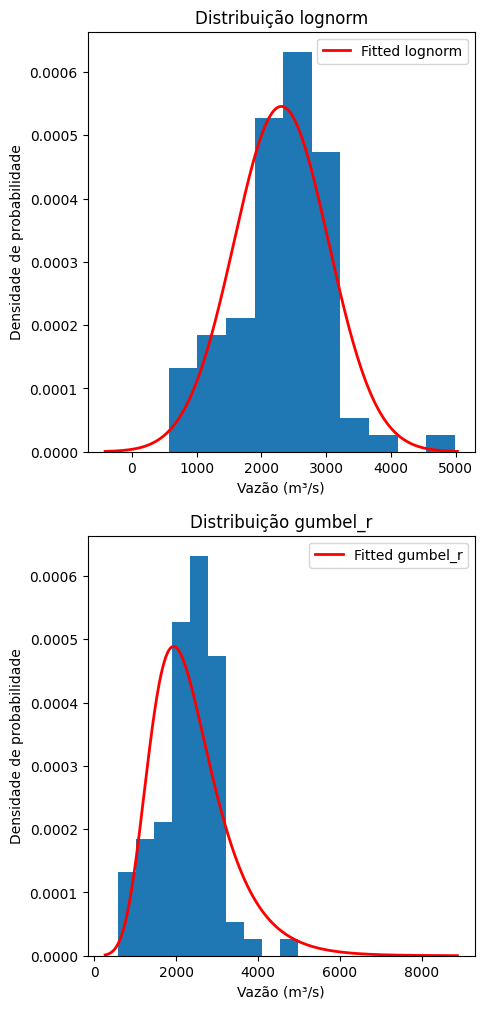

In [22]:
# d = copy.deepcopy(stations)
code, values = d.popitem()
print(f'Tempo de Retorno para {values["name"]} ({code})')

print(values['df'].head(10))
values['fig']

Tempo de Retorno para Dona Francisca (85400000)
    Ano Hidro   Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0   1941/1942  4984.2 1941-05-05         87.0      8001.0         58.0
1   2024/2025  3823.0 2024-05-02         43.5        52.5         12.8
2   1997/1998  3560.4 1997-10-16         29.0        23.1          9.2
3   1940/1941  3233.4 1940-07-17         21.8         9.8          6.1
4   2010/2011  3126.7 2010-01-05         17.4         7.6          5.4
..        ...     ...        ...          ...         ...          ...
81  1939/1940   820.6 1939-12-20          1.1         1.0          1.0
82  2006/2007   780.5 2006-07-28          1.0         1.0          1.0
83  1968/1969   727.1 1968-10-08          1.0         1.0          1.0
84  2004/2005   667.2 2004-11-10          1.0         1.0          1.0
85  1962/1963   570.0 1962-01-15          1.0         1.0          1.0

[86 rows x 6 columns]


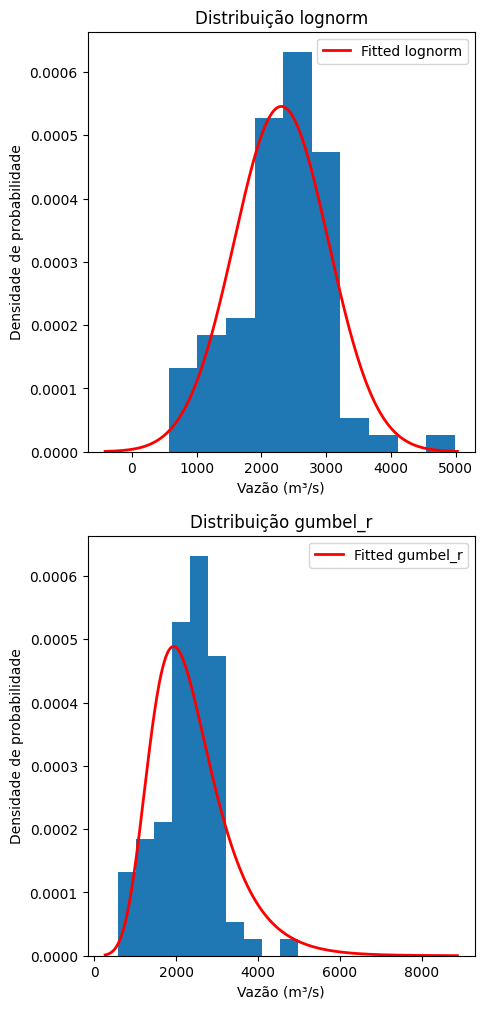

In [48]:
code, values = d.popitem()
print(f'Tempo de Retorno para {values["name"]} ({code})')

print(values['df'])
values['fig']

In [49]:
code, values = d.popitem()
print(f'Tempo de Retorno para {values["name"]} ({code})')

print(values['df'])
values['fig']

Tempo de Retorno para Estrela (86879300)


KeyError: 'df'

Tempo de Retorno para Muçum (86510000)
    Ano Hidro    Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0   2024/2025  13242.0 2024-05-02         86.0        57.5         39.2
1   2001/2002  12763.4 2001-10-01         43.0        44.9         32.1
2   2011/2012  12547.5 2011-07-21         28.7        40.2         29.4
3   1989/1990  11213.5 1989-09-12         21.5        20.6         17.0
4   1946/1947  10972.5 1946-01-26         17.2        18.3         15.4
..        ...      ...        ...          ...         ...          ...
80  2004/2005   1967.2 2004-07-16          1.1         1.1          1.1
81  1943/1944   1783.8 1943-08-03          1.0         1.0          1.0
82  1952/1953   1629.0 1952-06-09          1.0         1.0          1.0
83  2012/2013   1467.6 2012-09-21          1.0         1.0          1.0
84  1962/1963    588.9 1962-09-21          1.0         1.0          1.0

[85 rows x 6 columns]


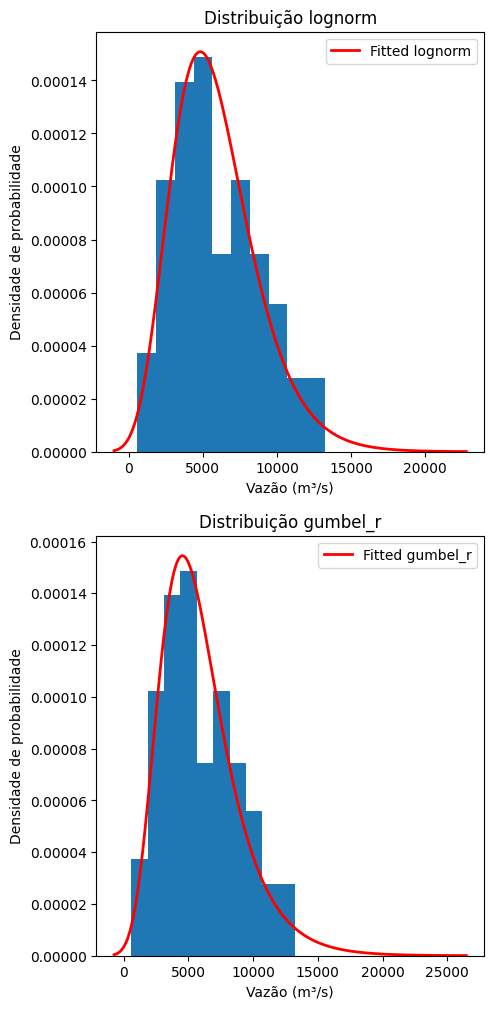

In [ ]:
code, values = d.popitem()
print(f'Tempo de Retorno para {values["name"]} ({code})')

print(values['df'])
values['fig']

In [ ]:
d.popitem()

(1, 3)

In [ ]:
d

{}

In [ ]:
code

86879300

In [ ]:
q = hydro.get_discharge(code)
q.loc[date, ['NivelConsistencia', 'EstacaoCodigo', 'Vazao']] = (1, code, max_q)

In [ ]:
maximum, fig = Hydrology.calc_return_times(q, 1)

Tempo de Retorno para Muçum (86510000)
    Ano Hidro    Vazao       Data  TR Empirico  TR lognorm  TR gumbel_r
0   2024/2025  13242.0 2024-05-02         86.0        46.0         35.6
1   2001/2002  12763.4 2001-10-01         43.0        36.6         29.3
2   2011/2012  12547.5 2011-07-21         28.7        33.1         26.9
3   1989/1990  11213.5 1989-09-12         21.5        17.8         15.7
4   1946/1947  10972.5 1946-01-26         17.2        16.0         14.3
5   1965/1966  10761.0 1965-08-19         14.3        14.5         13.2
6   2008/2009  10669.4 2008-10-27         12.3        13.9         12.7
7   1997/1998  10592.0 1997-08-04         10.8        13.5         12.3
8   1956/1957  10581.9 1956-04-05          9.6        13.4         12.3
9   2020/2021  10536.6 2020-07-08          8.6        13.1         12.0
10  1941/1942   9836.2 1941-05-05          7.8         9.7          9.2
11  2009/2010   9484.2 2009-09-12          7.2         8.3          8.0
12  2023/2024   9303.2 20

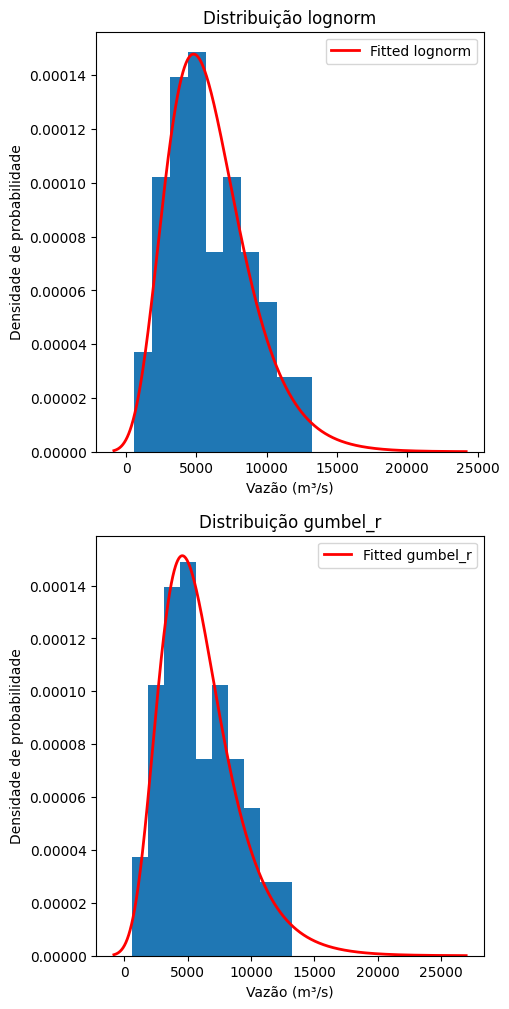

In [ ]:
# Tempo de Retorno - Muçum ()
print(f'Tempo de Retorno para {name} ({code})')
print(maximum.head(15))
fig

In [ ]:
q = pd.read_sql(
    sql='select * from hidro.estacao where Codigo = 86510000',
    con=hydro.conn,
)
stations

/tmp/ipykernel_1567/3451927587.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stations = pd.read_sql(


RegistroID  ...                                           geom_wkb
0   3736928.0  ...  b'\x01\x01\x00\x00\x00\x1e\xa7\xe8H.\xefI\xc0&...

[1 rows x 72 columns]

In [ ]:
stations

RegistroID  ...                                           geom_wkb
0       6896268.0  ...  b'\x01\x01\x00\x00\x00fffff\xc6G\xc0\xcd\xcc\x...
1       6896269.0  ...  b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\xc0...
2       6896270.0  ...  b'\x01\x01\x00\x00\x00\xcc\xee\xc9\xc3B\xadG\x...
3       6896271.0  ...  b'\x01\x01\x00\x00\x00\xcc\xee\xc9\xc3B\xedG\x...
4       6896272.0  ...  b'\x01\x01\x00\x00\x00x\x9c\xa2#\xb9\x8cG\xc0v...
...           ...  ...                                                ...
38135  38439616.0  ...  b'\x01\x01\x00\x00\x00[B>\xe8\xd9\xa8S\xc0\xa7...
38136  38439617.0  ...  b'\x01\x01\x00\x00\x00\xae\xb6b\x7f\xd9\xbdS\x...
38137  38439618.0  ...  b'\x01\x01\x00\x00\x00\x9bU\x9f\xab\xad\xe8S\x...
38138  38439619.0  ...  b'\x01\x01\x00\x00\x00p_\x07\xce\x19\x05T\xc0T...
38139  38439620.0  ...  b'\x01\x01\x00\x00\x00\xcc]K\xc8\x07\xcdS\xc0@...

[38140 rows x 72 columns]

In [ ]:

stations.query("ESTCOLETA == 'T' and ESTRESPONSAVEL == 1.0").head()

ESTCODIGO  ...                                           geom_wkb
2  113961120  ...  b"\x01\x01\x00\x00\x00\xecQ\xb8\x1e\x85\x9bN\x...
3   30667570  ...  b'\x01\x01\x00\x00\x00\xce\x88\xd2\xde\xe0\xfb...
4   12469250  ...  b'\x01\x01\x00\x00\x00\x1d8gDi[Q\xc0\xff\xb2{\...
5     867050  ...  b'\x01\x01\x00\x00\x00h"lxz\xc5P\xc0V}\xae\xb6...
6   72570010  ...  b'\x01\x01\x00\x00\x00=\n\xd7\xa3p\x81Q\xc0\x9...

[5 rows x 26 columns]

In [ ]:
stations.query("Codigo == 86510000")

RegistroID  ...                                           geom_wkb
37573   3736928.0  ...  b'\x01\x01\x00\x00\x00\x1e\xa7\xe8H.\xefI\xc0&...

[1 rows x 72 columns]

In [ ]:
stations.ESTCODIGO

0       261451040
1       263550450
2       113961120
3        30667570
4        12469250
          ...    
6459    202742590
6460    225750460
6461    224151380
6462    224951350
6463    224352260
Name: ESTCODIGO, Length: 6464, dtype: int64

In [ ]:
stations['ESTCOLETA'].unique()

array(['T', 'C'], dtype=object)

In [ ]:
pd.read_sql(
    sql='select * from hidro.pivotvazoes where EstacaoCodigo = 86510000 ORDER BY Data',
    con=hydro.conn,
)

/tmp/ipykernel_1567/4057191620.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(


RegistroID  EstacaoCodigo  ...  vazao_dia  vazao_data
0      60038717.0       86510000  ...         31  1940-01-31
1      60038717.0       86510000  ...         30  1940-01-30
2      60038717.0       86510000  ...         29  1940-01-29
3      60038717.0       86510000  ...         28  1940-01-28
4      60038717.0       86510000  ...         27  1940-01-27
...           ...            ...  ...        ...         ...
33065  80985474.0       86510000  ...         05  2024-01-05
33066  80985474.0       86510000  ...         04  2024-01-04
33067  80985474.0       86510000  ...         03  2024-01-03
33068  80985474.0       86510000  ...         02  2024-01-02
33069  80985474.0       86510000  ...         01  2024-01-01

[33070 rows x 12 columns]

In [ ]:
pd.read_sql(
    sql='select * from hidroInfoAna.Estacao where ESTCODIGO = 86510000',
    con=hydro.conn,
)

/tmp/ipykernel_1567/3351395661.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(


Empty DataFrame
Columns: [ESTCODIGO, ESTSUBBACIA, ESTRIO, ESTMUNICIPIO, ESTREGIAO, ESTRESPONSAVEL, ESTOPERADORA, ESTTIPO, ESTCOLETA, ESTORIGEM, ESTSTATUS, ESTCODIGOADICIONAL, ESTID, ESTANEELPLU, ESTANEELFLU, ESTNOME, ESTLATITUDE, ESTLONGITUDE, ESTALTITUDE, ESTINTERVALOTX, ESTINTERVALOCOLETA, ESTCONTADORCHUVA, ESTDESCRICAO, ESTHISTORICO, ESTULTIMAATUALIZACAO, geom_wkb]
Index: []

In [ ]:
pd.read_sql(
    sql='select * from hidroInfoAna.vazoes where HORESTACAO IN (291051520)',
    con=hydro.conn,
)


/tmp/ipykernel_1567/3421459255.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(


HORESTACAO         HORDATAHORA  ... HORQVAZAO  HORQVAZAOSTATUSANALISE
0       291051520.0 2024-05-07 12:00:00  ...       0.0                     1.0
1       291051520.0 2024-05-07 21:00:00  ...       0.0                     1.0
2       291051520.0 2024-05-07 01:00:00  ...       0.0                     1.0
3       291051520.0 2024-05-07 16:30:00  ...       0.0                     1.0
4       291051520.0 2024-05-08 00:15:00  ...       0.0                     1.0
...             ...                 ...  ...       ...                     ...
192567  291051520.0 2024-04-24 22:45:00  ...       0.0                     1.0
192568  291051520.0 2024-04-24 23:00:00  ...       0.0                     1.0
192569  291051520.0 2024-04-24 23:15:00  ...       0.0                     1.0
192570  291051520.0 2024-04-24 23:30:00  ...       0.0                     1.0
192571  291051520.0 2024-04-24 23:45:00  ...       0.0                     1.0

[192572 rows x 6 columns]

In [ ]:
len(stations)

0

In [ ]:
pd.read_sql(
    sql='select * from hidroInfoAna.Estacao',
    con=hydro.conn,
)

/tmp/ipykernel_1567/593501370.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(


ESTCODIGO  ...                                           geom_wkb
0     261451040.0  ...  b'\x01\x01\x00\x00\x005\xef8EG\x8aI\xc0\xb57\x...
1     263550450.0  ...  b'\x01\x01\x00\x00\x00\xa1\xd64\xef8]I\xc0ffff...
2     113961120.0  ...  b"\x01\x01\x00\x00\x00\xecQ\xb8\x1e\x85\x9bN\x...
3      30667570.0  ...  b'\x01\x01\x00\x00\x00\xce\x88\xd2\xde\xe0\xfb...
4      12469250.0  ...  b'\x01\x01\x00\x00\x00\x1d8gDi[Q\xc0\xff\xb2{\...
...           ...  ...                                                ...
6459  202742590.0  ...  b'\x01\x01\x00\x00\x00\xe4\x14\x1d\xc9\xe5\x7f...
6460  225750460.0  ...  b'\x01\x01\x00\x00\x00\t\xf9\xa0g\xb3bI\xc0\xa...
6461  224151380.0  ...  b'\x01\x01\x00\x00\x00\xe0\xbe\x0e\x9c3\xd2I\x...
6462  224951350.0  ...  b'\x01\x01\x00\x00\x00\xb1\xbf\xec\x9e<\xccI\x...
6463  224352260.0  ...  b'\x01\x01\x00\x00\x00\x9aw\x9c\xa2#9J\xc0\t\x...

[6464 rows x 26 columns]

In [ ]:
cursor = hydro.conn.execute('select * from hidroInfoAna.Estacao') # where ESTCODIGO IN (86510000)
cursor.fetchall()

[(Decimal('261451040'), Decimal('65'), Decimal('65100000'), Decimal('22283000'), None, Decimal('1163'), Decimal('1163'), 'H', 'T', Decimal('3'), Decimal('0'), '65310001', '9709F25A (DESATIVADO', Decimal('2651059'), Decimal('65310001'), 'UHE GOV. BENTO MUNHOZ UNIÃO DA VITÓRIA', Decimal('-26.22810'), Decimal('-51.08030'), Decimal('739.00'), Decimal('60'), Decimal('60'), Decimal('4095'), 'RES. ANA/ANEEL N. 03/2010', 'Colocada desativada em 14/08/20014; Ultimo Dado registrado em 27/07/2009 ás 09h:00m. Os dados da origem Res_Conj_3 passarão a ser recebidos pelo Telemetria II Em: 15/06/2015 15:31:46, esta estação foi atualizada.\r\n* 26/05/2022 11:49:14 - Sincronismo: Estação desativada. Motivo: Estação não possui Plano de Trabalho.\r\n* 26/05/2022 11:49:14 - Sincronismo: Estação desativada. Motivo: Estação não possui Plano de Trabalho.\r\n* 26/05/2022 11:49:30 - Sincronismo: Estação desativada. Motivo: Estação não possui Plano de Trabalho.\r\n* 26/05/2022 11:49:30 - Sincronismo: Estação des

In [ ]:
 ('syndb_hidro', 'hidroInfoAna', 'Estacao', 'BASE TABLE'),
